In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

!jupytext --to py:percent vote_analysis_public.ipynb

[jupytext] Reading vote_analysis_public.ipynb in format ipynb
[jupytext] Writing vote_analysis_public.py in format py:percent (destination file replaced)


# We load the votes per item

In [2]:
# we define the coding of the answers: 1 for "AGREE", 0 for "NO OPINION", -1 for "DISAGREE"
possible_answers = ["AGREE", "NO OPINION", "DISAGREE"]
answers_to_coding = dict(zip(possible_answers, [1, 0, -1]))
coding_to_answers = {v: k for k, v in answers_to_coding.items()}

In [3]:
# we load the excel file containing the votes
df = pd.read_excel("final_base_vote_en.xlsx")

# We check data consistency
we perform a simple test to check there is no mistake in the collection of the data in the Excel sheet.

In [4]:
def summary_stats(df):
    df = df.apply(pd.Series.value_counts, dropna=False)
    df.index = df.index.map(coding_to_answers)
    return df


# data consistency. We validate that for each question the sum of the three
# possible answers per college is 100% of the size of the college (no error in the data
# summarizing the three types of answers)
# We must have a single value per college.
nb_voters_per_college = (
    df.iloc[:, 1:]
    .groupby("College", observed=True)
    .apply(summary_stats,include_groups=False)
    #.fillna(0)
    .groupby("College", observed=True)
    .sum()
    .apply(pd.Series.unique, axis=1)
)
nb_voters_per_college


College
Health operators     [32.0]
Healthcare Users     [76.0]
Professionals       [315.0]
Researchers          [80.0]
dtype: object

# We compute basic statistics

### Number of voters per profession

In [5]:
professions = df.loc[:, "Profession"].value_counts()
professions.to_csv(os.path.join("Stats", "professions_stats.csv"))

### How many item answered per voter

In [6]:
# we compute how many items have been voted on by each participant. 
# We only count votes 1 (AGREE) and -1 (DISAGREE), 
# we do not count 0 (NO OPINION)
how_many_items_answered_per_voter = df.iloc[:, 2:].copy()
# answers 1 and -1 are counted as answered
how_many_items_answered_per_voter = how_many_items_answered_per_voter.replace(-1, 1).sum(axis=1)

In [7]:
# distribution of the number of questions answered
distribution_of_answers_per_voter = how_many_items_answered_per_voter.value_counts().sort_index()

# distribution of the number of questions answered in percentage
distribution_of_answers_per_voter_percentage = (distribution_of_answers_per_voter/503*100).round(0)

Text(0, 0.5, 'Percentage of voters')

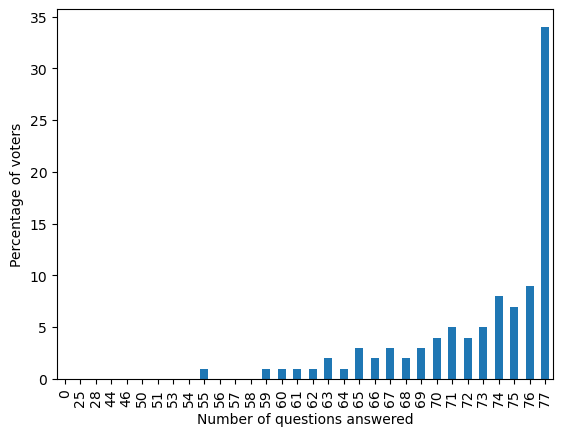

In [8]:
distribution_of_answers_per_voter_percentage.plot.bar()
plt.xlabel("Number of questions answered")
plt.ylabel("Percentage of voters")

In [9]:
print(f"There are {distribution_of_answers_per_voter_percentage.loc[70:].sum()}% of the voters voting for at least 70 items and {distribution_of_answers_per_voter_percentage.loc[60:].sum()}% voting for at least 60 items.")

There are 76.0% of the voters voting for at least 70 items and 95.0% voting for at least 60 items.


# Data statistics

In [10]:
# We validated there is a single value per college, therefore, we only keep
# the first (and only one) value of the series to get a scalar value per college
nb_voters_per_college = nb_voters_per_college.str[0].to_dict()
colleges = list(nb_voters_per_college.keys())
nb_voters_per_college

{'Health operators': 32.0,
 'Healthcare Users': 76.0,
 'Professionals': 315.0,
 'Researchers': 80.0}

In [11]:
# we computer the per college stats
per_college_stats = df.iloc[:, 1:].groupby("College", observed=True).apply(summary_stats, include_groups=False).fillna(0)
with open(os.path.join("Stats","per_college_stats.md"), "w") as f:
    f.write(per_college_stats.T.to_markdown())

In [12]:
# we remove the "NO OPINION" column
voters_percentage = per_college_stats.reset_index(level=1)
voters_percentage = voters_percentage[voters_percentage["level_1"] == 'NO OPINION'].drop(columns='level_1').astype('Float32')

# we compute the percentage of voters who voted for each question per college
for college in nb_voters_per_college.keys():
    voters_percentage.loc[college, :] = voters_percentage.loc[college, :] / nb_voters_per_college[college] * 100

### Impact of the item order on the number of votes

sum of voters who skipped the first and last item: 22.0, 17.0
sum of voters who skipped the first ten and last ten items: 331.0, 257.0
sum of voters who skipped the first half and the last half of the items: 998.0, 1483.0


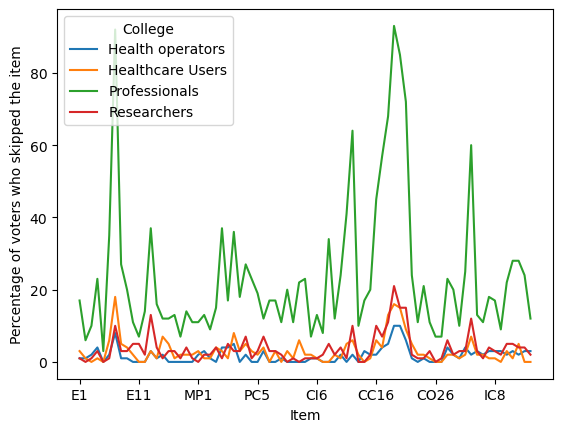

In [13]:
# evolution with time of the number of dropped questions
voters_percentage = per_college_stats.reset_index(level=1)
evolution_with_time_dropped_questions = (
    voters_percentage[voters_percentage["level_1"] == "NO OPINION"]
    .drop(columns="level_1")
    .astype("Float32")
)
evolution_with_time_dropped_questions.T.plot()
plt.xlabel("Item")
plt.ylabel("Percentage of voters who skipped the item")
plt.savefig(os.path.join("Fig", "evolution_with_time_dropped_questions.png"), dpi=300)

summed_evolution_with_time_dropped_questions = (
    evolution_with_time_dropped_questions.sum(axis=0)
)
print(
    f"sum of voters who skipped the first and last item: {summed_evolution_with_time_dropped_questions.iloc[0].sum()}, {summed_evolution_with_time_dropped_questions.iloc[-1].sum()}"
)
print(
    f"sum of voters who skipped the first ten and last ten items: {summed_evolution_with_time_dropped_questions.iloc[:10].sum()}, {summed_evolution_with_time_dropped_questions.iloc[-10:].sum()}"
)
print(
    f"sum of voters who skipped the first half and the last half of the items: {summed_evolution_with_time_dropped_questions.iloc[:38].sum()}, {summed_evolution_with_time_dropped_questions.iloc[38:].sum()}"
)

The two tail p-value for the first question is 0.81363 and for the 10 questions is 0.55225


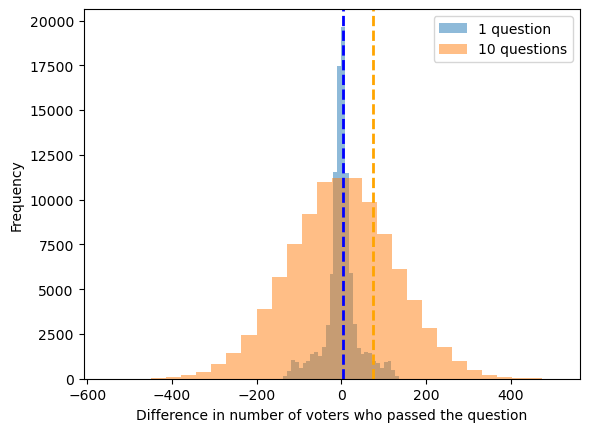

In [14]:
# We will test the hypothesis that the order of the questions has no impact on the number of voters who passed the question
# We will use a permutation test to test this hypothesis

# We will shuffle the order of the questions and compute the statistics for each permutation
# We will then compute the two-tail p-value as the fraction of permutations with a statistics greater or equal to the observed statistics
# or less or equal to the negative of the observed statistics
# We will use 100_000 permutations

rng = np.random.default_rng()
votes = summed_evolution_with_time_dropped_questions.to_numpy().copy()
# Observed data
observed_statistics_1 = votes[0] - votes[-1]
observed_statistics_10 = votes[:10].sum() - votes[-10:].sum()

# we compute the p-value for the 1 statistics
num_permutations = 100_000
diffs_1 = []
for _ in range(num_permutations):
    # shuffle the order of the questions
    rng.shuffle(votes)
    # compute the statistics for the shuffled order
    diff = votes[0] - votes[-1]
    diffs_1.append(diff)

# Compute a twp-tailed p-value (fraction of permutations with difference ≥ observed difference)
p_value_1 = np.mean((np.array(diffs_1) >= observed_statistics_1) | (np.array(diffs_1) <= -observed_statistics_1))

# we compute the p-value for the 10 statistics
num_permutations = 100_000
diffs_10 = []
for _ in range(num_permutations):
    # shuffle the order of the questions
    rng.shuffle(votes)
    # compute the statistics for the shuffled order
    diff = votes[:10].sum() - votes[-10:].sum()
    diffs_10.append(diff)

# Compute a twp-tailed p-value (fraction of permutations with difference ≥ observed difference)
p_value_10 = np.mean((np.array(diffs_10) >= observed_statistics_10) | (np.array(diffs_10) <= -observed_statistics_10))

# we plot the histogram of the differences
plt.hist(diffs_1, bins=30, alpha=0.5, label='1 question')
plt.hist(diffs_10, bins=30, alpha=0.5, label='10 questions')
plt.axvline(observed_statistics_1, color='b', linestyle='dashed', linewidth=2)
plt.axvline(observed_statistics_10, color='orange', linestyle='dashed', linewidth=2)
# add a legend
plt.legend()
plt.xlabel('Difference in number of voters who passed the question')
plt.ylabel('Frequency')
plt.savefig(os.path.join("Fig", "permutation_test.png"), dpi=300)

print(f"The two tail p-value for the first question is {p_value_1} and for the 10 questions is {p_value_10}")

### Compute the stats based on voters that answered
The voters that are counted as 'NO OPINION' are excluded in the computation of the ratio of voters that are 'AGREE'

In [15]:
# we compute the percentage of agreement for each item per college
college_agreement_percentage = {}
for college in colleges:
    college_agreement_percentage[college] = (
        per_college_stats.loc[(college, "AGREE"), :]
        / (
            per_college_stats.loc[(college, "AGREE")]
            + per_college_stats.loc[(college, "DISAGREE")]
        )
        * 100
    )
college_agreement_percentage = pd.DataFrame(college_agreement_percentage)

# we check that all questions received at least 80% positive answers per college
assert (college_agreement_percentage > 80).all(axis=None)

In [16]:
# we add a study type column to the dataframe
college_agreement_percentage["Study type"] = pd.NA
college_agreement_percentage["Study type"] = college_agreement_percentage["Study type"].astype("string")
college_agreement_percentage.loc[
    college_agreement_percentage.index.isin(
        [
            "E1",
            "E2",
            "E3",
            "E4",
            "E5",
            "E6",
            "E7",
            "E8",
            "E9",
            "E10",
            "E11",
            "E12",
            "E13",
            "E14",
        ]
    ),
    "Study type",
] = "Ethical"
college_agreement_percentage.loc[
    college_agreement_percentage.index.isin(["OP1", "OP2", "OP3", "OI4", "OC5", "OO6"]), "Study type"
] = "Observational"
college_agreement_percentage.loc[
    college_agreement_percentage.index.isin(["MP1", "MP2", "MI3", "MI4", "MC5", "MO6"]), "Study type"
] = "Mechanistic"
college_agreement_percentage.loc[
    college_agreement_percentage.index.isin(["PP1", "PP2", "PP3", "PI4", "PC5", "PC6", "PO7", "PO8", "PO9"]),
    "Study type",
] = "Prototypical"
college_agreement_percentage.loc[
    college_agreement_percentage.index.isin(
        [
            "CP1",
            "CP2",
            "CP3",
            "CP4",
            "CI5",
            "CI6",
            "CI7",
            "CI8",
            "CI9",
            "CI10",
            "CC11",
            "CC12",
            "CC13",
            "CC14",
            "CC15",
            "CC16",
            "CC17",
            "CC18",
            "CC19",
            "CC20",
            "CC21",
            "CO22",
            "CO23",
            "CO24",
            "CO25",
            "CO26",
            "CO27",
            "CO28",
        ]
    ),
    "Study type",
] = "Intervention"
college_agreement_percentage.loc[
    college_agreement_percentage.index.isin(
        [
            "IP1",
            "IP2",
            "II3",
            "II4",
            "II5",
            "IC6",
            "IC7",
            "IC8",
            "IC9",
            "IC10",
            "IC11",
            "IO12",
            "IO13",
            "IO14",
        ]
    ),
    "Study type",
] = "Implementation"


college_agreement_percentage = college_agreement_percentage.reset_index().set_index("Study type").rename(columns={"index": "Item"})

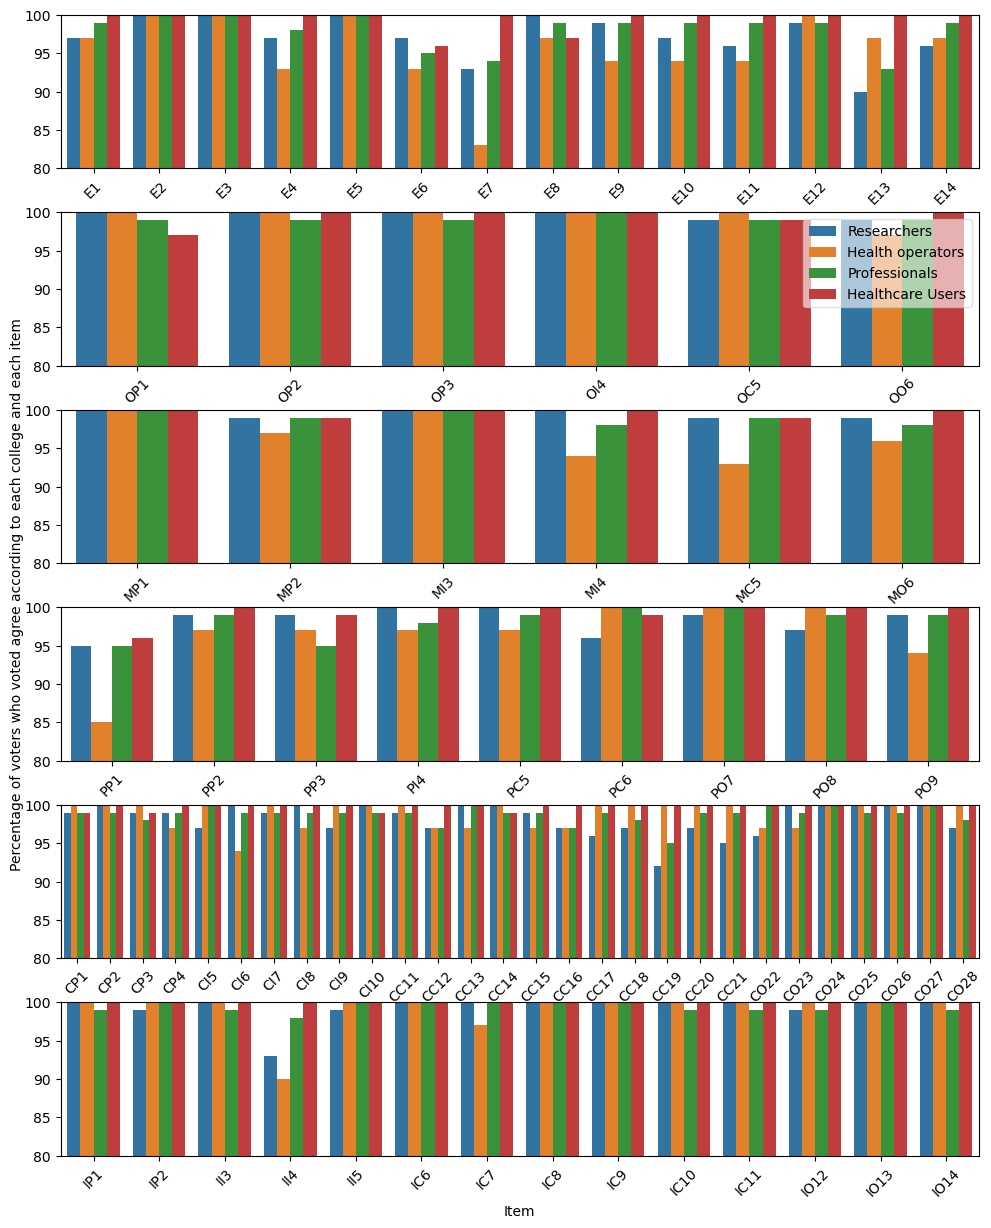

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

In [17]:
# we round all percentages to integers
college_agreement_percentage = pd.concat(
    [college_agreement_percentage.iloc[:, 0], college_agreement_percentage.iloc[:, 1:].round(0).astype("UInt8")], axis=1
)

college_agreement_melt = college_agreement_percentage.reset_index()

college_agreement_melt = college_agreement_melt.melt(
    id_vars=["Study type", "Item"],
    value_vars=["Researchers", "Health operators", "Professionals", "Healthcare Users"],
    var_name="College",
)

f, axes = plt.subplots(6, 1, figsize=(10, 12))
plt.tight_layout()
for cpt, cat in enumerate(college_agreement_melt["Study type"].unique()):
    plt.figure(figsize=(10, 2))
    axes[cpt].set_ylim(80, 100)
    b = sns.barplot(
        data=college_agreement_melt[college_agreement_melt["Study type"] == cat],
        y="value",
        x="Item",
        hue="College",
        ax=axes[cpt],
    )
    if cpt != 1:
        b.legend_.remove()
    else:
        axes[cpt].legend(fancybox=True, framealpha=0.6)

    axes[cpt].tick_params(labelrotation=45, axis="x")
    axes[cpt].set_ylabel("")

f.text(
    0.005,
    0.5,
    "Percentage of voters who voted agree according to each college and each item",
    va="center",
    rotation="vertical",
)
f.savefig(os.path.join("Fig", "vote_en.png"), dpi=300)